In [20]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal


class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128,
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())

        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))

        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones):

        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):

            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                b_advantage = b_returns.detach() - self.v_model(b_states)

                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)

                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))

                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()

                v_loss = torch.mean(b_advantage ** 2)

                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


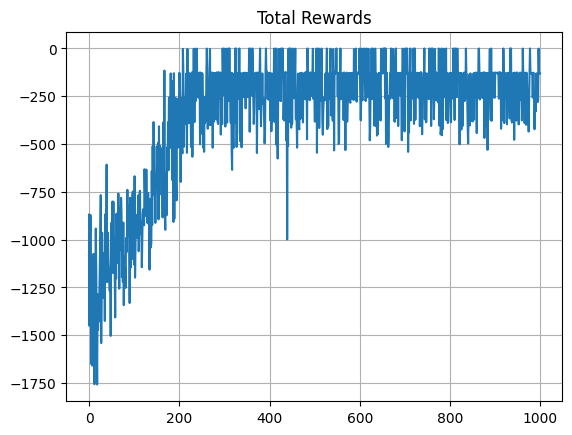

In [21]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO(state_dim, action_dim)

episode_n = 50
trajectory_n = 20

total_rewards = []

for episode in range(episode_n):

    states, actions, rewards, dones = [], [], [], []

    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(200):
            states.append(state)

            action = agent.get_action(state)
            actions.append(action)

            state, reward, done, _ = env.step(2 * action)
            rewards.append(reward)
            dones.append(done)

            total_reward += reward

        total_rewards.append(total_reward)

    agent.fit(states, actions, rewards, dones)

plt.plot(total_rewards)
plt.title('Total Rewards')
plt.grid()
plt.show()

In [22]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal

class PPONew(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128,
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())

        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))

        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones):

        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        states, actions = map(torch.FloatTensor, [states, actions])

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):

            idxs = np.random.permutation(actions.shape[0]-1)
            for i in range(0, actions.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_next_states = states[b_idxs+1]
                b_dones = dones[b_idxs]
                b_rewards = rewards[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                b_advantage = torch.tensor(b_rewards) + torch.tensor((1.0 - b_dones)) * self.gamma * self.v_model(b_next_states) - self.v_model(b_states)

                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)

                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))

                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()

                v_loss = torch.mean(b_advantage ** 2)

                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

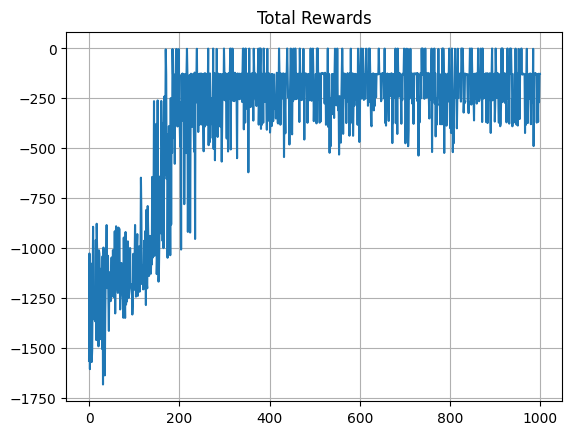

In [23]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPONew(state_dim, action_dim)

episode_n = 50
trajectory_n = 20

total_rewards_new = []

for episode in range(episode_n):

    states, actions, rewards, dones = [], [], [], []

    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(200):
            states.append(state)

            action = agent.get_action(state)
            actions.append(action)

            state, reward, done, _ = env.step(2 * action)
            rewards.append(reward)
            dones.append(done)

            total_reward += reward

        total_rewards_new.append(total_reward)

    agent.fit(states, actions, rewards, dones)

plt.plot(total_rewards_new)
plt.title('Total Rewards')
plt.grid()
plt.show()

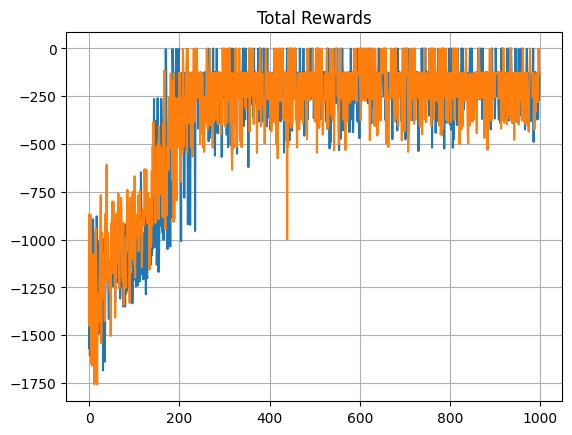

In [34]:
plt.plot(total_rewards_new)
plt.plot(total_rewards)
plt.title('Total Rewards')
plt.grid()
plt.show()

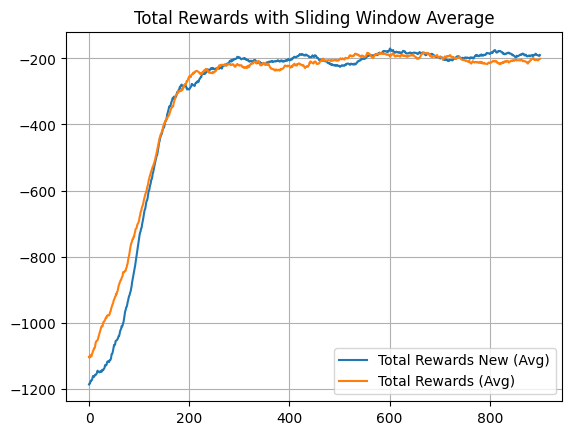

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def sliding_window_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size


window_size = 100

avg_total_rewards_new = sliding_window_average(total_rewards_new, window_size)
avg_total_rewards = sliding_window_average(total_rewards, window_size)

plt.plot(avg_total_rewards_new, label='Total Rewards New (Avg)')
plt.plot(avg_total_rewards, label='Total Rewards (Avg)')
plt.title('Total Rewards with Sliding Window Average')
plt.grid()
plt.legend()
plt.show()


In [43]:
total_rewards_new

[-1565.4867021681005,
 -1027.5461063793384,
 -1607.136735165462,
 -1074.9288093033424,
 -1568.0002735588812,
 -1274.578908195877,
 -1571.4197095578097,
 -1512.861638514247,
 -1179.060260672224,
 -893.7201692336984,
 -1321.48517769,
 -1357.5269169411674,
 -1204.5964811660324,
 -1196.906112867262,
 -1368.0112053203543,
 -959.7623322393803,
 -1461.388810306576,
 -878.6569046604262,
 -1018.5296603988623,
 -1093.6696284283814,
 -1049.5212995306554,
 -1492.705854241918,
 -1011.3753912463435,
 -1029.4584372186525,
 -1163.697625471521,
 -1456.9595085135159,
 -1104.5508508606292,
 -1130.6163600797292,
 -1170.5183545917728,
 -1506.0550195952535,
 -1041.3235204134521,
 -1683.9604852682207,
 -998.0053421395526,
 -1066.0707104497012,
 -1287.7160632030022,
 -1638.4288205129044,
 -1319.0823075545948,
 -1132.5857552754649,
 -1051.30814574177,
 -885.2362339540234,
 -1201.1493647442217,
 -1056.007740332171,
 -1039.055314609114,
 -1256.7981070167366,
 -1415.4790074486614,
 -1121.7771882364202,
 -1173.674